In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
Xs = torch.from_numpy(np.load('squares/obs.npy')).float()
Mus = torch.from_numpy(np.load('squares/mus.npy')).float()
Xs = Xs.transpose(1,2)

B, N, D = Xs.shape
## Model Parametersnum_hidden
NUM_SAMPLES = 10
NUM_HIDDEN = 32
NUM_LATENTS = 2
NUM_OBS = D
BATCH_SIZE = 100
NUM_EPOCHS = 20000
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_log_u_a = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.enc_log_u_b = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))

    def forward(self, obs, num_samples):
        h = self.enc_h(obs) # (B, H)
        a = torch.exp(self.enc_log_u_a(h)) # (S, B, 1)
        b = torch.exp(self.enc_log_u_b(h)) # (S, B, 1)
        q_u = Beta(a, b)
        u = q_u.sample((num_samples,)) # (S, B, 1)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.01 * torch.ones((N, num_obs))

        self.dec_mu = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, obs, num_samples):
        mu = self.dec_mu(u) # (S, B, K+1) -> (S, B, O)
        p_x = Normal(mu, self.x_sigma.repeat(num_samples, 1, 1)) # (S, B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (S, B)
        return mu, log_p_x

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc = Encoder()
    dec = Decoder()
#     enc.apply(weights_init)
    opt1 =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99)) 
    opt2 = torch.optim.Adam(list(dec.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    return enc, dec, opt1, opt2
enc, dec, opt1, opt2 = initialize()

In [5]:
def oneshot(x, mean, N, D, num_samples):
    data = x - mean
    X_mus = torch.zeros((num_samples, N, D))
    u, log_q = enc(data, num_samples)
    mu, log_p_x = dec(u, data, num_samples)
    pr_u = Uniform(torch.zeros(N, NUM_LATENTS), torch.ones(N, NUM_LATENTS))
    log_pr_u = pr_u.log_prob(u).sum(-1)
    log_weights = (log_pr_u + log_p_x - log_q)
    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()

    return eubo, elbo, mu, u

In [6]:
ELBOs = []
EUBOs = []
time_start = time.time()

for epoch in range(NUM_EPOCHS):
    for b in range(B):
        X = Xs[b]
        mean = Mus[b]
        indices = torch.randperm(N)
        X_shuffle = X[indices]
        opt1.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        eubo.backward()
        opt1.step()
        opt2.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        (-elbo).backward()
        opt2.step()
    
        ELBOs.append(elbo.item())
        EUBOs.append(eubo.item())
    

    time_end = time.time()  
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f (%ds)' % (epoch, eubo, elbo, time_end - time_start))
    time_start = time.time()


epoch=0, EUBO=-5825.604, ELBO=-7112.311 (1s)
epoch=1, EUBO=-5127.794, ELBO=-6455.687 (1s)
epoch=2, EUBO=-4485.502, ELBO=-5878.104 (1s)
epoch=3, EUBO=-3849.499, ELBO=-5235.807 (1s)
epoch=4, EUBO=-3270.106, ELBO=-4470.823 (1s)
epoch=5, EUBO=-2724.840, ELBO=-3845.825 (1s)
epoch=6, EUBO=-2261.708, ELBO=-3248.748 (1s)
epoch=7, EUBO=-1841.386, ELBO=-2732.419 (1s)
epoch=8, EUBO=-1475.668, ELBO=-2249.697 (1s)
epoch=9, EUBO=-1161.653, ELBO=-1840.692 (1s)
epoch=10, EUBO=-886.643, ELBO=-1500.930 (1s)
epoch=11, EUBO=-671.696, ELBO=-1232.430 (1s)
epoch=12, EUBO=-494.794, ELBO=-1018.491 (1s)
epoch=13, EUBO=-357.033, ELBO=-856.783 (1s)
epoch=14, EUBO=-254.863, ELBO=-728.951 (1s)
epoch=15, EUBO=-163.520, ELBO=-599.594 (1s)
epoch=16, EUBO=-114.306, ELBO=-534.889 (1s)
epoch=17, EUBO=-79.580, ELBO=-465.580 (1s)
epoch=18, EUBO=-62.468, ELBO=-404.332 (1s)
epoch=19, EUBO=-50.234, ELBO=-352.331 (1s)
epoch=20, EUBO=-46.284, ELBO=-329.200 (1s)
epoch=21, EUBO=-37.673, ELBO=-300.328 (1s)
epoch=22, EUBO=-33.544, 

KeyboardInterrupt: 

In [9]:
torch.save(enc.state_dict(), 'VAE/enc-square')
torch.save(dec.state_dict(), 'VAE/dec-square')

In [10]:
P = 3
eubo, elbo, mu, u = oneshot(Xs[P], Mus[P], N, D, NUM_SAMPLES)

(-0.1, 1.1)

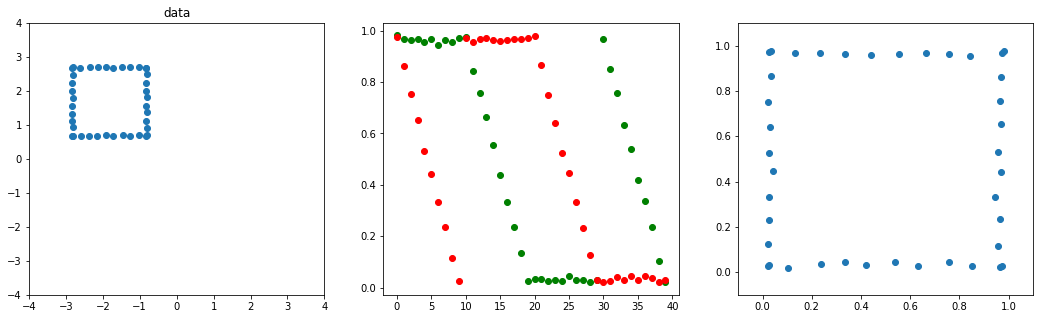

In [13]:
T = 40
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)
ax1.scatter(Xs[P,:T, 0].data.numpy(), Xs[P, :T, 1].data.numpy())
ax1.set_xlim([-4,4])
ax1.set_ylim([-4,4])
ax1.set_title('data')

uu = u.mean(0)
ax2.plot(uu[:T, 0].data.numpy(), 'go')
ax2.plot(uu[:T, 1].data.numpy(), 'ro')

ax3.scatter(uu[:T, 0].data.numpy(), uu[:T, 1].data.numpy())
ax3.set_xlim([-0.1,1.1])
ax3.set_ylim([-0.1,1.1])

In [ ]:
T = 150
plt.scatter(Xs[:T, 0].data.numpy(), Xs[:T, 1].data.numpy())
plt.xlim([-3,3])
plt.ylim([-3,3])

In [ ]:
for s in range(NUM_SAMPLES):
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)   
    ax1.scatter(mu[s, :, 0].data.numpy(), mu[s, :, 1].data.numpy())
#     ax2.scatter(Xs_shuffle[:, 0].data.numpy(), Xs_shuffle[:, 1].data.numpy())
    ax1.set_xlim([-3,3])
    ax1.set_ylim([-3,3])


In [ ]:
a = torch.linspace(0.0, 0.2, 100)[:, None]
angles = dec.dec_angles(a) 
rads = dec.dec_rad(a)
x_mus = angles * rads

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(x_mus[:, 0].data.numpy(), x_mus[:, 1].data.numpy())
ax1.set_xlim([-3,3])
ax1.set_ylim([-3,3])